In [86]:
import pandas as pd
import random as rd
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import deque, defaultdict

In [87]:
class QTable:
    def __init__(self):
        self.Q = defaultdict(lambda: defaultdict(lambda: 0.0))
    
    def _state_to_tuple(self, state):
        return tuple(sorted((edge, tuple(sorted(ages))) for edge, ages in state.items()))
    
    def storeStateActionValue(self, state, action, value):
        state_tuple = self._state_to_tuple(state)
        action_tuple = tuple(tuple(edge) for edge in action)
        self.Q[state_tuple][action_tuple] = value
    
    def getValue(self, state, action):
        state_tuple = self._state_to_tuple(state)
        action_tuple = tuple(tuple(edge) for edge in action)
        return self.Q[state_tuple][action_tuple]
    
    def getActionAndValues(self, state):
        state_tuple = self._state_to_tuple(state)
        return [(action, value) for action, value in self.Q[state_tuple].items()]


def epsilonGreedyPolicy(Q, state, epsilon, env):
    actions_and_values = Q.getActionAndValues(state)
    
    if not actions_and_values:
        possible_actions = env.getPossibleActions()
        return rd.choice(possible_actions)
    
    if np.random.rand() < epsilon:
        return random.choice(actions_and_values)[0]
    else:
        return max(actions_and_values, key=lambda x: x[1])[0]



In [135]:

class QuantumNetwork:
    def __init__(self, initialEdges, pGen, pSwap, cutOffAge, maxLinks):
        self.initialEdges = initialEdges
        self.pGen = pGen
        self.pSwap = pSwap
        self.cutOffAge = cutOffAge
        self.nodeCapacity = nodeCapacity  # Dictionary mapping node -> max entanglements
        
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(sorted(nodes))
    
    def reset(self):
        self.G = nx.Graph()
        nodes = set()
        for edge in self.initialEdges:
            nodes.add(edge[0])
            nodes.add(edge[1])
        self.G.add_nodes_from(nodes)
    
    def setState(self, state):
        self.G = nx.Graph()
        for edge, entanglements in state.items():
            self.G.add_edge(*edge, entanglements=deque(entanglements))
    
    def getNodeEntanglementCount(self, node):
        """Count total entanglements a node is involved in"""
        return sum(len(self.G.edges[e]['entanglements']) 
                  for e in self.G.edges(node)) if self.G.degree(node) > 0 else 0
        
    def generateLocalEntanglement(self, node1, node2):
        edge = tuple(sorted([node1, node2]))
        
        # Check if either node has reached its capacity
        node1_count = self.getNodeEntanglementCount(node1)
        node2_count = self.getNodeEntanglementCount(node2)
        
        if (node1_count >= self.nodeCapacity[node1] or 
            node2_count >= self.nodeCapacity[node2]):
            return 
        
        if not self.G.has_edge(*edge):
            self.G.add_edge(*edge, entanglements=deque([0]))
        else:
            self.G.edges[edge]['entanglements'].appendleft(0)
            
    def getState(self):
        edge_info = {}
        for edge in self.G.edges():
            edge_info[edge] = list(self.G.edges[edge]['entanglements']) 
        return edge_info
        
    def ageEntanglements(self):
        edges_to_check = list(self.G.edges())  # Create a copy of edges to iterate over
        for edge in edges_to_check:
            entanglements = self.G.edges[edge]['entanglements']
            # Remove entanglements that would exceed cutOffAge
            while entanglements and entanglements[-1] + 1 > self.cutOffAge:
                self.discardEntanglement(edge)
            # Age remaining entanglements
            if self.G.has_edge(*edge):  # Check if edge still exists
                entanglements = self.G.edges[edge]['entanglements']
                self.G.edges[edge]['entanglements'] = deque(age + 1 for age in entanglements)
    
    def generateGlobalEntanglementsProbabalistically(self):
        for edge in self.initialEdges:
            if rd.random() < self.pGen:
                self.generateLocalEntanglement(*edge)
    
    # def generateLocalEntanglement(self, node1, node2):
    #     edge = tuple(sorted([node1, node2]))
        
    #     node1_entanglements = sum(len(self.G.edges[e]['entanglements']) 
    #                             for e in self.G.edges(node1)) if self.G.degree(node1) > 0 else 0
    #     node2_entanglements = sum(len(self.G.edges[e]['entanglements']) 
    #                             for e in self.G.edges(node2)) if self.G.degree(node2) > 0 else 0
        
    #     if node1_entanglements >= self.maxLinks or node2_entanglements >= self.maxLinks:
    #         return 
        
    #     if not self.G.has_edge(*edge):
    #         self.G.add_edge(*edge, entanglements=deque([0]))
    #     else:
    #         if len(self.G.edges[edge]['entanglements']) < self.maxLinks:
    #             self.G.edges[edge]['entanglements'].appendleft(0)
    
    def discardEntanglement(self, edge: tuple):
        if self.G.has_edge(*edge):
            if len(self.G.edges[edge]['entanglements']) > 0:
                self.G.edges[edge]['entanglements'].pop()
            if len(self.G.edges[edge]['entanglements']) == 0:
                self.G.remove_edge(*edge)
                
         
    def drawNetwork(self):
        plt.figure(figsize=(12, 8))
        plt.clf()
        
        G_viz = self.G.copy()
        G_viz.add_edges_from(self.initialEdges)
        
        # FIXED POSITION FOR DUMBELL NETWORK
        pos = {
            0: (-1, 0.5),   # Top left
            1: (-1, -0.5),  # Bottom left
            2: (0, 0),      # Center
            3: (1, 0),      # Center right
            4: (2, 0.5),    # Top right
            5: (2, -0.5)    # Bottom right
        }
        # pos = nx.spring_layout(G_viz, seed=27)

        nx.draw_networkx_edges(G_viz, pos=pos, 
                            edgelist=self.initialEdges,
                            edge_color='grey',
                            style='dashed',
                            alpha=0.5)
        
        for edge in self.G.edges():
            entanglements = self.G.edges[edge]['entanglements']
            for i, age in enumerate(entanglements):
                nx.draw_networkx_edges(G_viz, pos=pos,
                                    edgelist=[edge],
                                    edge_color='blue',
                                    width=2,
                                    arrows=True,
                                    connectionstyle=f'arc3, rad={-0.1 + i*0.2}')
                
                edge_x = (pos[edge[0]][0] + pos[edge[1]][0]) / 2
                edge_y = (pos[edge[0]][1] + pos[edge[1]][1]) / 2
                offset = -0.1 + i*0.2
                label_x = edge_x + offset * (pos[edge[1]][1] - pos[edge[0]][1]) / 2
                label_y = edge_y - offset * (pos[edge[1]][0] - pos[edge[0]][0]) / 2
                plt.text(label_x, label_y, str(age), 
                        bbox=dict(facecolor='white', edgecolor='lightgray', alpha=0.7))
        
        nx.draw_networkx_nodes(G_viz, pos=pos, node_color='lightblue')
        nx.draw_networkx_labels(G_viz, pos=pos)
        
        plt.show()
        
        

In [161]:
"""
N-Step Lookahead with Q-Learning

1. Start with currentState, currentNetwork
actions = possibleActions(currentNetwork)
2. For each action in actions:
    reward = 0
    tempNetwork = copy(currentNetwork)
    
    # Look ahead n steps
    reward = recursiveLookahead(tempNetwork, depth=1, maxDepth=n, gamma=gamma)
    
    # Update Q-value for this state-action pair (Q-learning update rule)
    oldQ = Q.getValue(currentState, action)
    newQ = oldQ + alpha * (reward - oldQ)
    Q.storeStateActionValue(currentState, action, newQ)

Choose action based on epsilon-greedy policy (so Q-values are used).

function recursiveLookahead(network, depth, maxDepth, gamma):
    if depth == maxDepth:
        return network.getReward()
    
    possibleActions = network.getPossibleActions()
    maxReward = 0
    
    for action in possibleActions:
        tempNetwork = copy(network)
        tempNetwork.takeAction(action)
        tempNetwork.ageEntanglements()
        tempNetwork.generateGlobalEntanglementsProbabalistically()
        
        reward = (gamma ** depth) * recursiveLookahead(tempNetwork, depth + 1, maxDepth, gamma)
        maxReward = max(maxReward, reward)
    
    return maxReward
"""


# TODO: WHAT DO WE DO WITH LINKS AFTER WE'VE FORMED THEM, AS THEY ARE TAKING UP QUBITS BUT WE HAVEN'T USED THEM
# TODO: NO ERROR CHECKING FOR SWAPS
# TODO: LET DESTROY ENTANGLEMENTS BE A ACTION WE CAN TAKE
# TODO: [{'swaps': [], 'goal': (0, 5)}, {'swaps': [], 'goal': None}]

class WaitSwapEnvironment(QuantumNetwork):
    def __init__(self, initialEdges, pGen, pSwap, cutOffAge, nodeCapacity, goalEdgesAndWeights):
        super().__init__(initialEdges, pGen, pSwap, cutOffAge, nodeCapacity)
        self.goalEdgesAndWeights = goalEdgesAndWeights
        self.averageRate = defaultdict(lambda: 0.0)
        
    def getReward(self):
        pass     
    
    def copy(self):
        new_env = WaitSwapEnvironment(self.initialEdges, self.pGen, self.pSwap, self.cutOffAge, self.nodeCapacity, self.goalEdgesAndWeights)
        
        # Copy the current graph state
        new_env.G = self.G.copy()  # NetworkX has a built-in copy method
        
        # Copy the entanglements for each edge
        for edge in new_env.G.edges():
            new_env.G.edges[edge]['entanglements'] = deque(self.G.edges[edge]['entanglements'])
        
        return new_env
    
    def recursiveLookahead(network, depth, maxDepth, gamma):
        pass

    def takeAction(self, action):
        if action['swaps']: 
            for edge1, edge2 in action['swaps']:
                
                self.discardEntanglement(edge1)
                
                self.discardEntanglement(edge2)

            if action['goal']:
                self.generateLocalEntanglement(*action['goal'])
        
        final_state = self.getState()
        return final_state
    
    def getPossibleActions(self):
        possible_actions = []
        
        for goal_edge, _ in self.goalEdgesAndWeights:
            start_node, end_node = goal_edge
            
            if nx.has_path(self.G, start_node, end_node):
                paths = list(nx.all_simple_paths(self.G, start_node, end_node))
                for path in paths:
                    # Get all edges in the path, always sorted
                    path_edges = []
                    for i in range(len(path)-1):
                        edge = tuple(sorted([path[i], path[i+1]]))
                        path_edges.append(edge)
                    
                    # Check if all edges exist in graph (accounting for either order)
                    has_entanglements = all(
                        self.G.has_edge(*edge) or self.G.has_edge(*tuple(reversed(edge)))
                        for edge in path_edges
                    )
                    
                    if has_entanglements:
                        possible_actions.append({
                            'swaps': [(edge1, edge2) for edge1, edge2 in zip(path_edges[:-1], path_edges[1:])],
                            'goal': goal_edge
                        })
        
        possible_actions.append({
            'swaps': [],
            'goal': None
        })

        return possible_actions

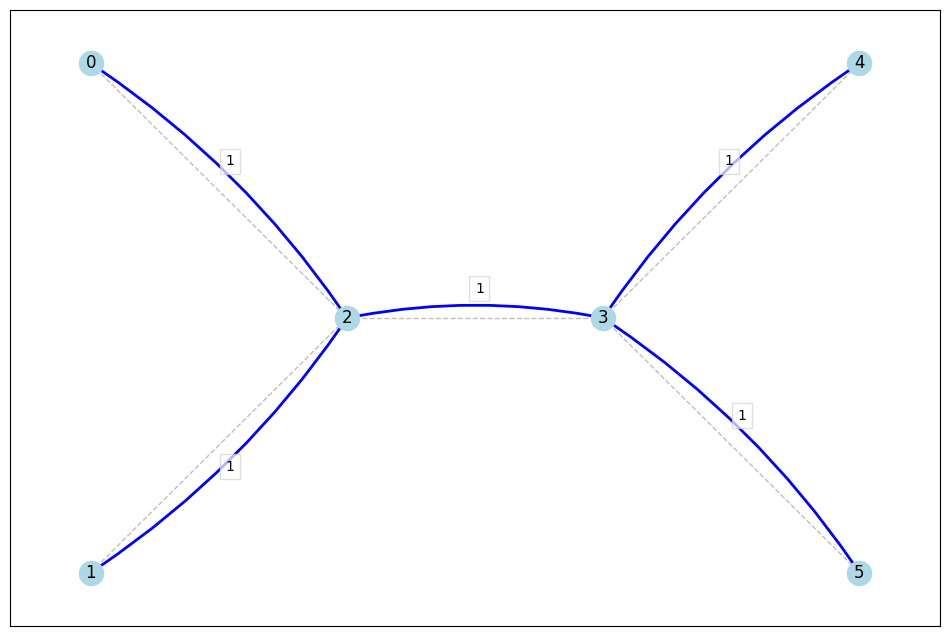

Initial State:
{(0, 2): [1], (2, 1): [1], (2, 3): [1], (3, 4): [1], (3, 5): [1]}
Possible Actions:
[{'swaps': [((0, 2), (2, 3)), ((2, 3), (3, 5))], 'goal': (0, 5)}, {'swaps': [((1, 2), (2, 3)), ((2, 3), (3, 4))], 'goal': (1, 4)}, {'swaps': [], 'goal': None}]

=== First Action 1 ===
Taking action: {'swaps': [((0, 2), (2, 3)), ((2, 3), (3, 5))], 'goal': (0, 5)}
State after first action:
{(0, 5): [0], (2, 1): [1], (3, 4): [1]}


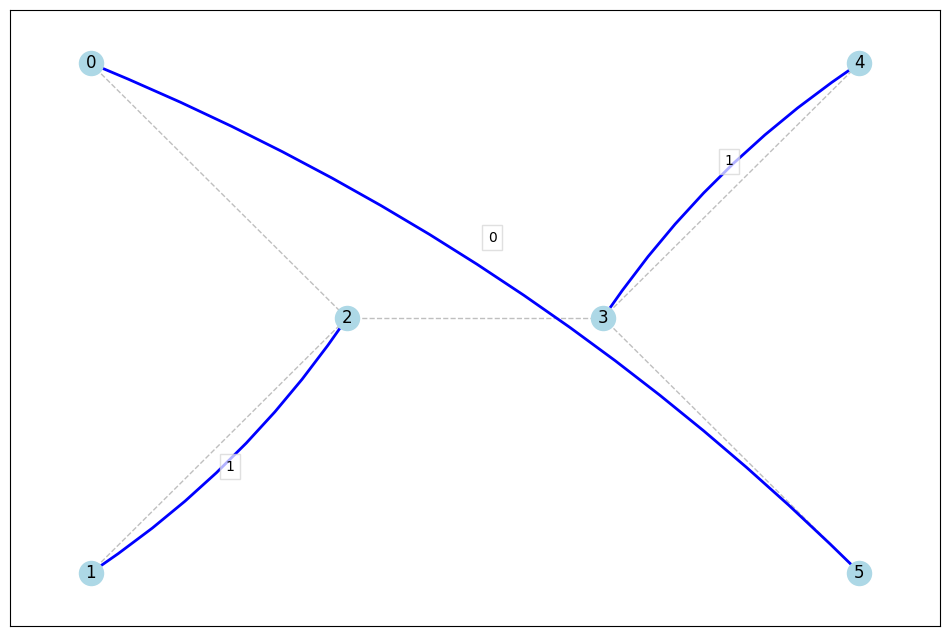


Aging and generating new entanglements...
State after aging and generation:
{(0, 5): [1], (2, 1): [2], (3, 4): [2]}


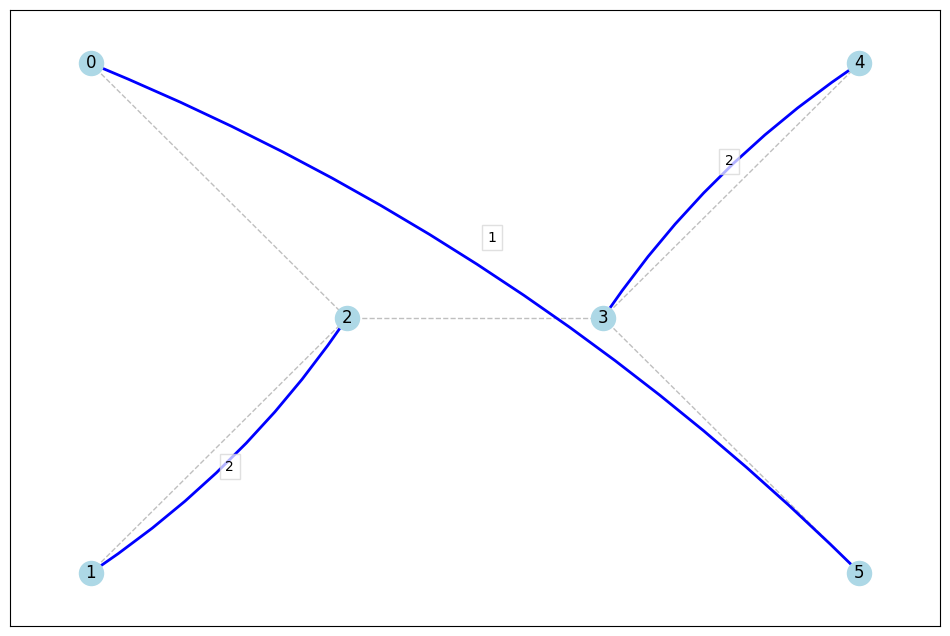


Possible second actions from state 1:
[{'swaps': [], 'goal': (0, 5)}, {'swaps': [], 'goal': None}]

--- Second Action 1.1 ---
Taking action: {'swaps': [], 'goal': (0, 5)}
State after second action:
{(0, 5): [1], (2, 1): [2], (3, 4): [2]}


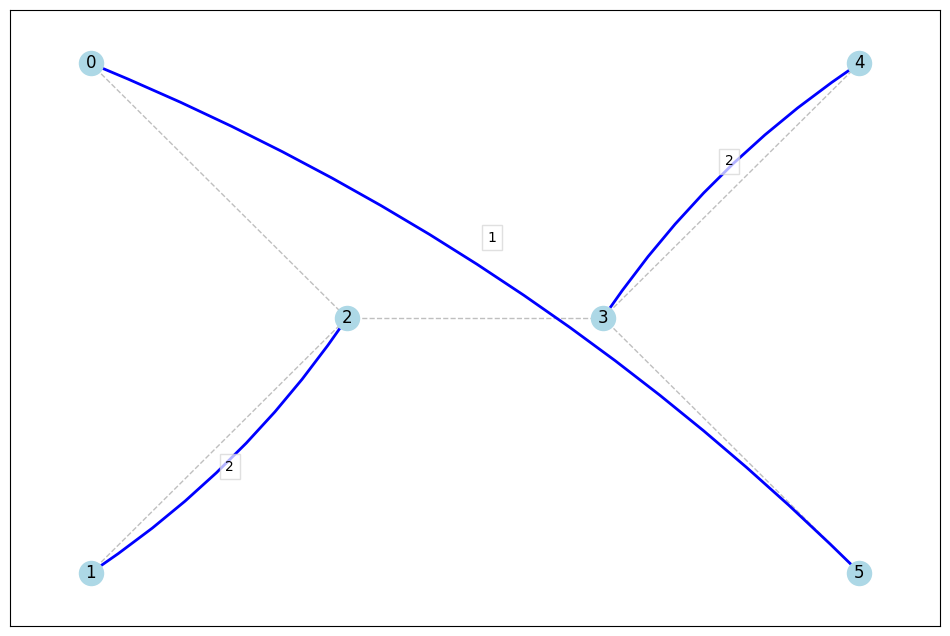


--- Second Action 1.2 ---
Taking action: {'swaps': [], 'goal': None}
State after second action:
{(0, 5): [1], (2, 1): [2], (3, 4): [2]}


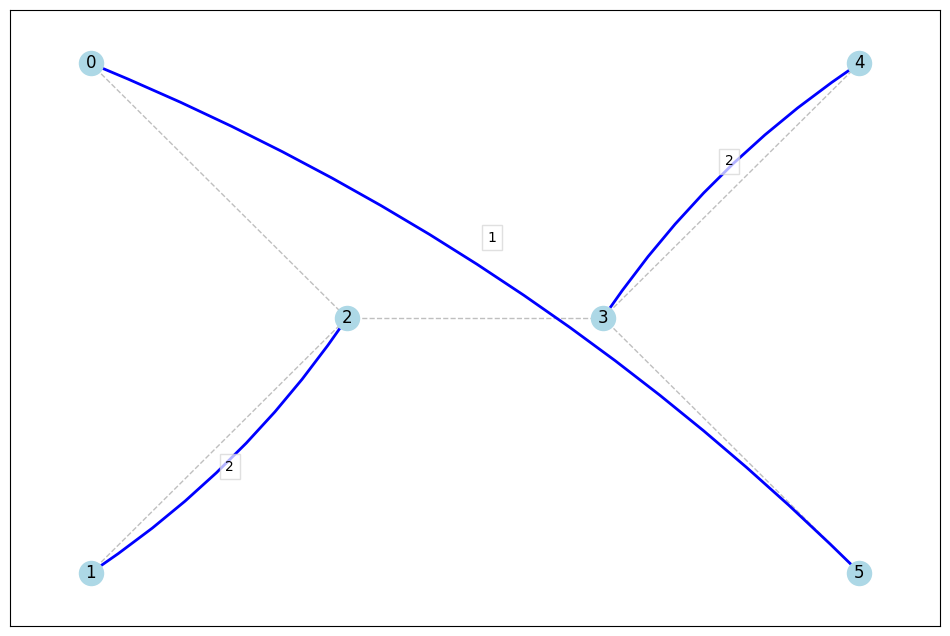


=== First Action 2 ===
Taking action: {'swaps': [((1, 2), (2, 3)), ((2, 3), (3, 4))], 'goal': (1, 4)}
State after first action:
{(0, 2): [1], (1, 4): [0], (3, 5): [1]}


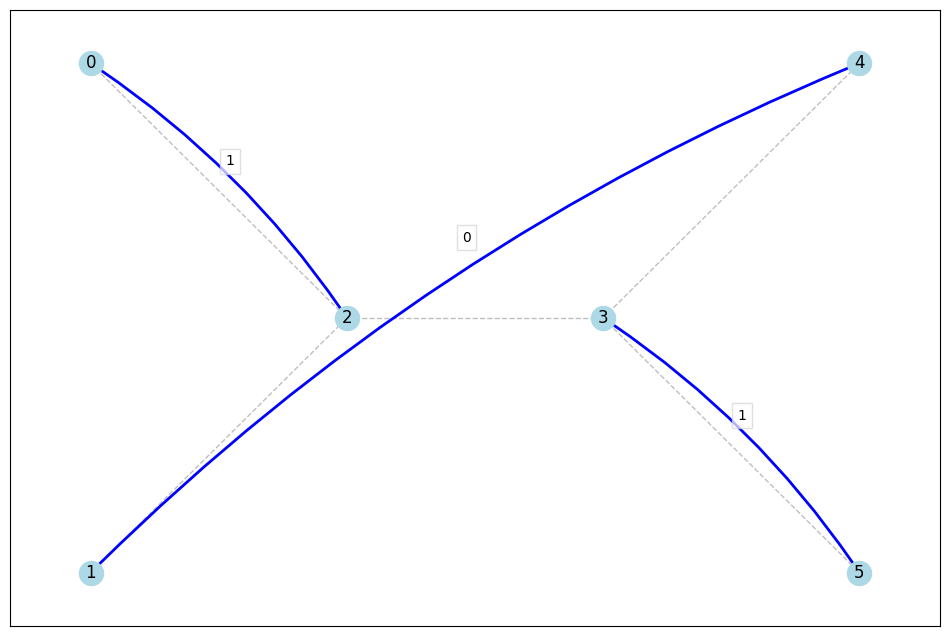


Aging and generating new entanglements...
State after aging and generation:
{(0, 2): [2], (1, 4): [1], (3, 5): [2]}


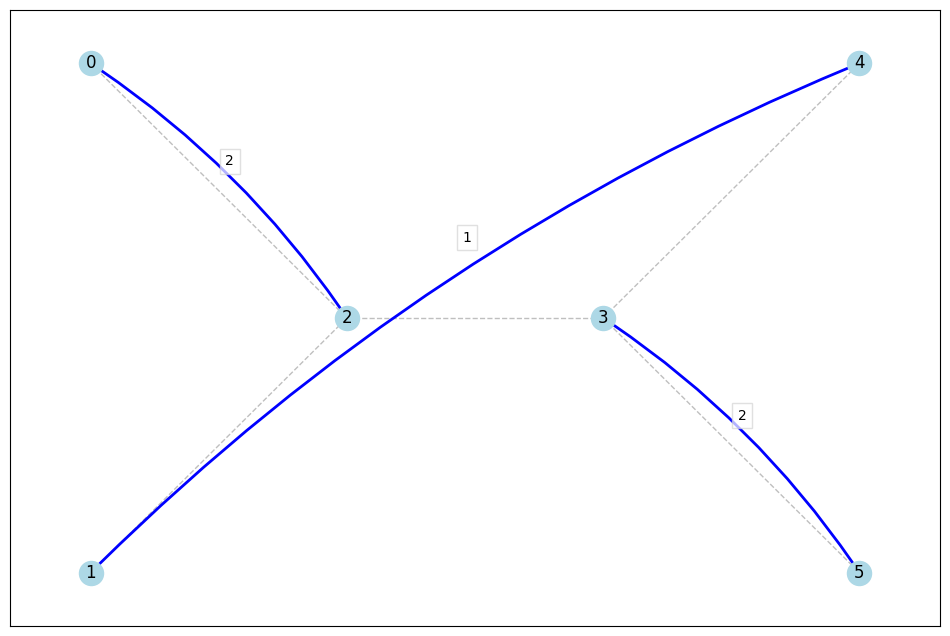


Possible second actions from state 2:
[{'swaps': [], 'goal': (1, 4)}, {'swaps': [], 'goal': None}]

--- Second Action 2.1 ---
Taking action: {'swaps': [], 'goal': (1, 4)}
State after second action:
{(0, 2): [2], (1, 4): [1], (3, 5): [2]}


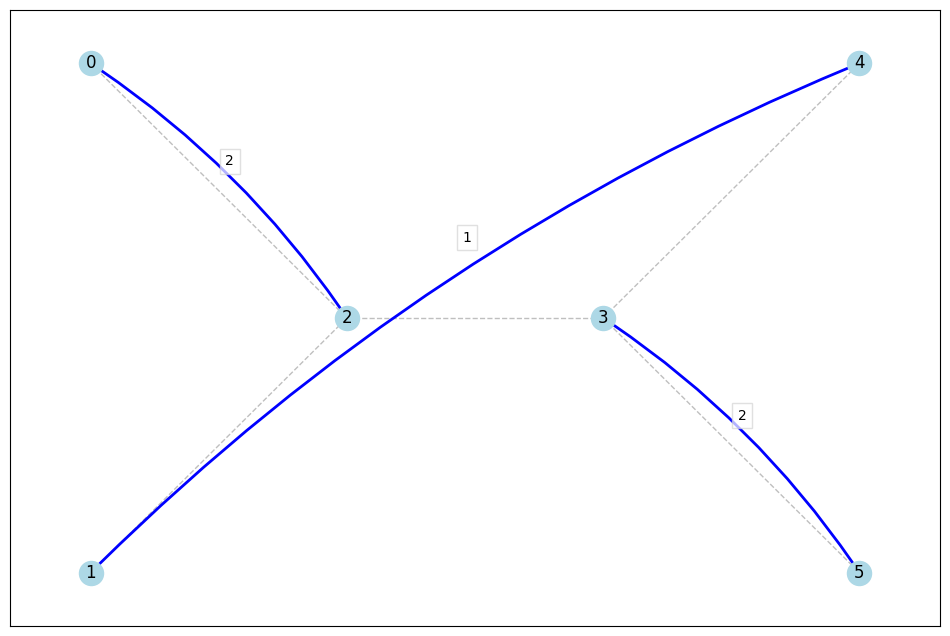


--- Second Action 2.2 ---
Taking action: {'swaps': [], 'goal': None}
State after second action:
{(0, 2): [2], (1, 4): [1], (3, 5): [2]}


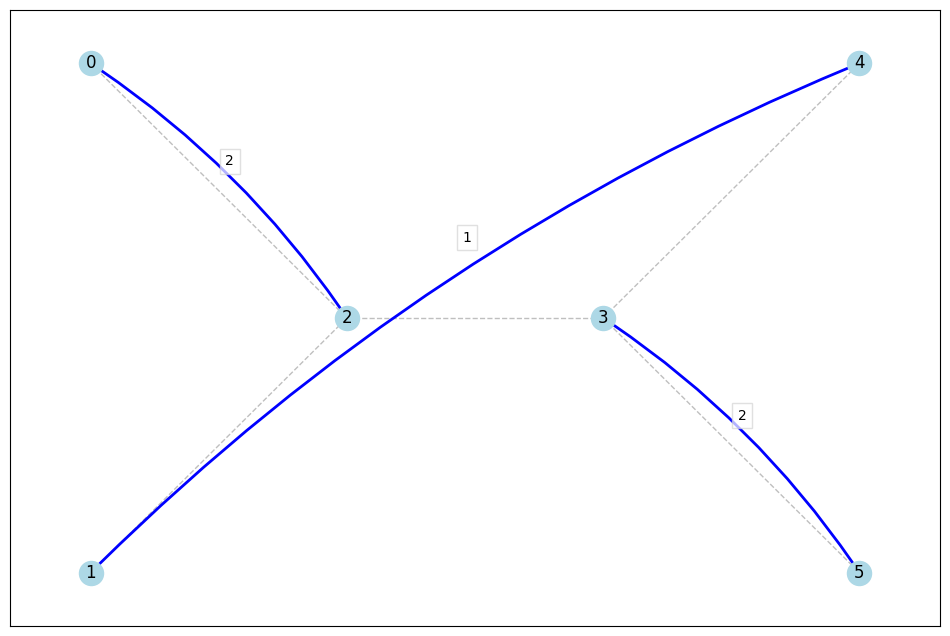


=== First Action 3 ===
Taking action: {'swaps': [], 'goal': None}
State after first action:
{(0, 2): [1], (2, 1): [1], (2, 3): [1], (3, 4): [1], (3, 5): [1]}


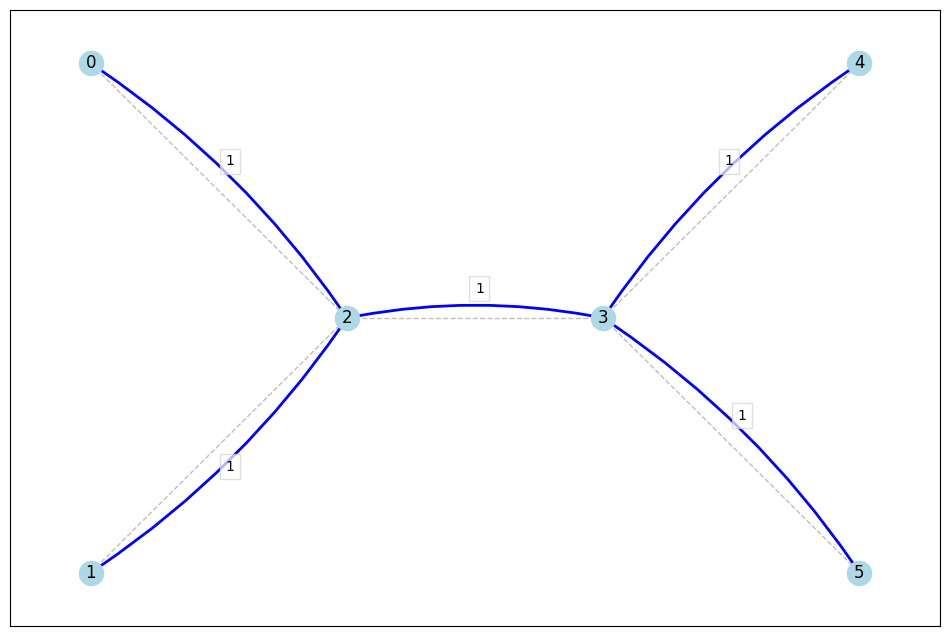


Aging and generating new entanglements...
State after aging and generation:
{(0, 2): [2], (2, 1): [2], (2, 3): [2], (3, 4): [2], (3, 5): [2]}


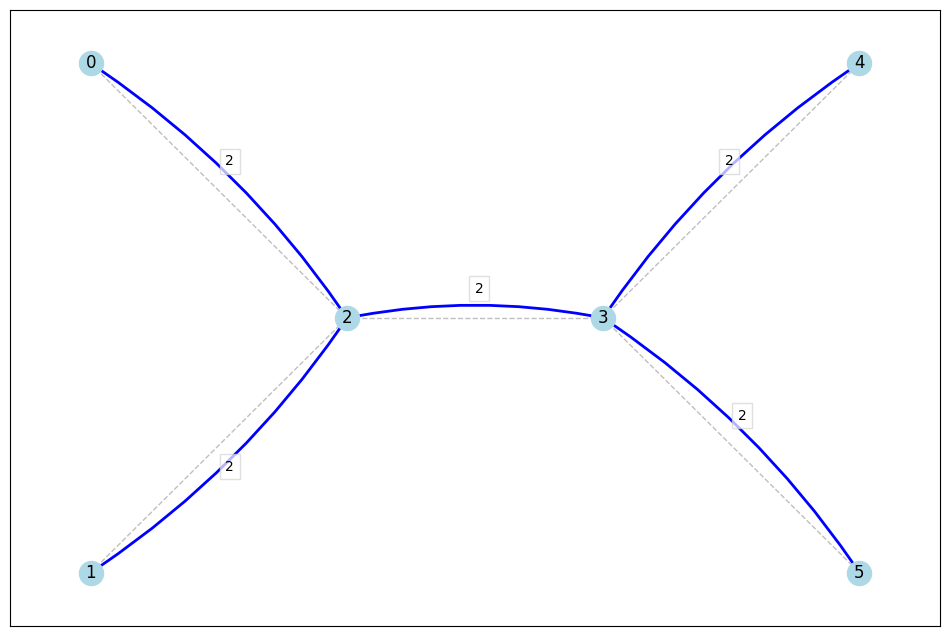


Possible second actions from state 3:
[{'swaps': [((0, 2), (2, 3)), ((2, 3), (3, 5))], 'goal': (0, 5)}, {'swaps': [((1, 2), (2, 3)), ((2, 3), (3, 4))], 'goal': (1, 4)}, {'swaps': [], 'goal': None}]

--- Second Action 3.1 ---
Taking action: {'swaps': [((0, 2), (2, 3)), ((2, 3), (3, 5))], 'goal': (0, 5)}
State after second action:
{(0, 5): [0], (2, 1): [2], (3, 4): [2]}


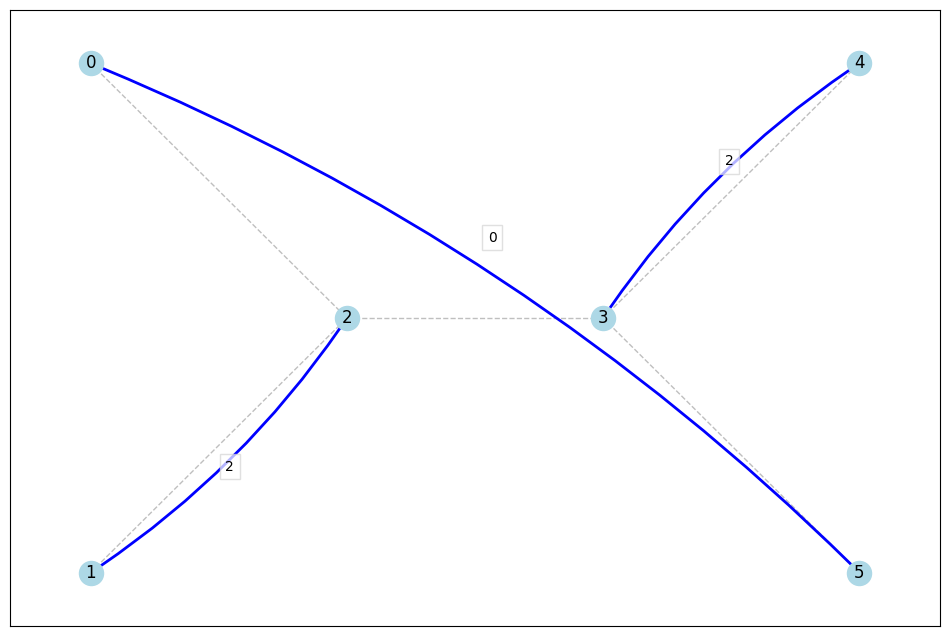


--- Second Action 3.2 ---
Taking action: {'swaps': [((1, 2), (2, 3)), ((2, 3), (3, 4))], 'goal': (1, 4)}
State after second action:
{(0, 2): [2], (1, 4): [0], (3, 5): [2]}


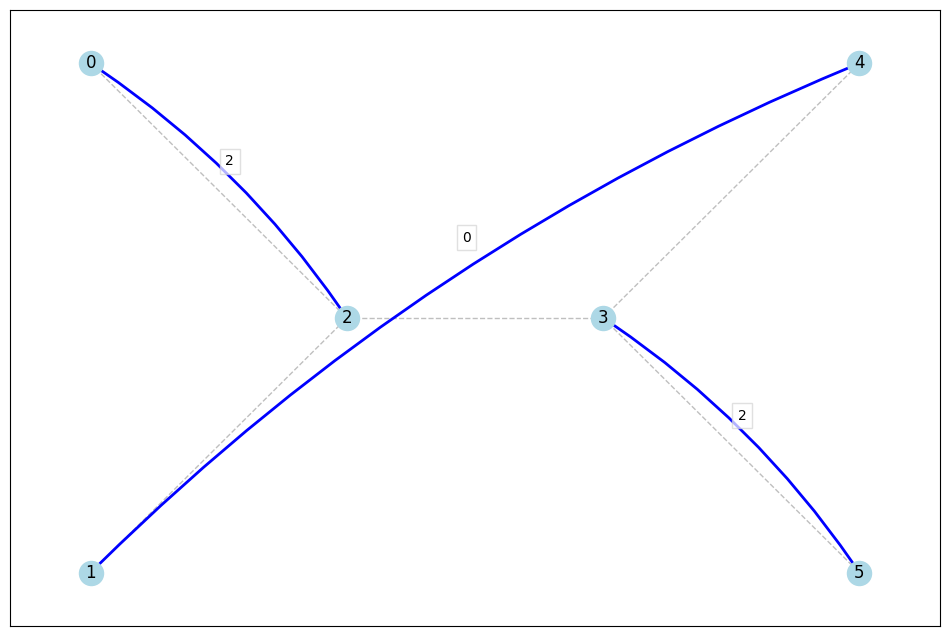


--- Second Action 3.3 ---
Taking action: {'swaps': [], 'goal': None}
State after second action:
{(0, 2): [2], (2, 1): [2], (2, 3): [2], (3, 4): [2], (3, 5): [2]}


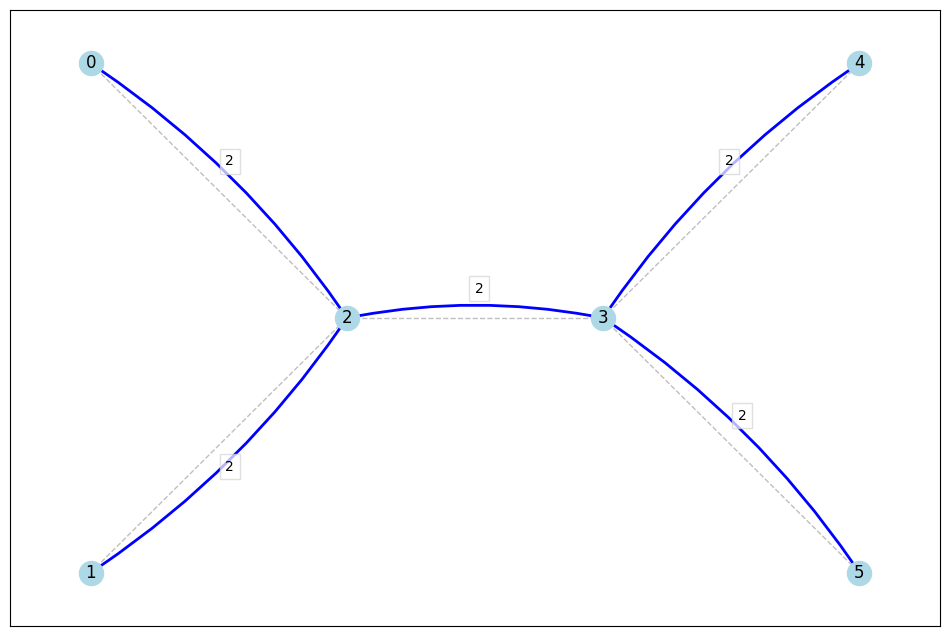

In [164]:

# For some reason, the seed needs to be set here, otherwise the results are different every time
SEED = 1
rd.seed(SEED)
np.random.seed(SEED)

# Initalise Network
# nodeCapacity is initialised manually for now 
nodeCapacity = {
    0: 1,  # node 0 can only have 1 entanglement
    1: 1,  # node 1 can only have 1 entanglement
    2: 3,  # node 2 can have 3 entanglements
    3: 3,  # node 3 can have 3 entanglements
    4: 1,  # node 4 can only have 1 entanglement
    5: 1   # node 5 can only have 1 entanglement
}


initialEdges = [
    (0, 2),
    (1, 2),
    (2, 3),
    (3, 4),
    (3, 5)]
goalEdgesAndWeights = [((0,5), 0.7), ((1,4), 0.3)]
network = WaitSwapEnvironment(initialEdges=initialEdges, pGen=0.7,pSwap=1, cutOffAge=2, nodeCapacity=nodeCapacity, goalEdgesAndWeights=goalEdgesAndWeights) 
# Generate initial entanglements
network.setState({(0, 2): [0], (1, 2): [0], (2, 3): [0], (3, 4): [0], (3, 5): [0]})
network.ageEntanglements()
network.drawNetwork()
print("Initial State:")
print(network.getState())
print('Possible Actions:')
myActions = network.getPossibleActions()
print(myActions)
counter = 1
for action1 in myActions:
    print(f"\n=== First Action {counter} ===")
    print("Taking action:", action1)
    tempNetwork1 = network.copy()
    tempNetwork1.takeAction(action1)
    
    print("State after first action:")
    print(tempNetwork1.getState())
    tempNetwork1.drawNetwork()
    
    print("\nAging and generating new entanglements...")
    tempNetwork1.ageEntanglements()
    tempNetwork1.generateGlobalEntanglementsProbabalistically()
    
    print("State after aging and generation:")
    print(tempNetwork1.getState())
    tempNetwork1.drawNetwork()
    
    # Get possible actions for the second step
    secondActions = tempNetwork1.getPossibleActions()
    print(f"\nPossible second actions from state {counter}:")
    print(secondActions)
    
    # For each possible second action
    for action2_idx, action2 in enumerate(secondActions, 1):
        print(f"\n--- Second Action {counter}.{action2_idx} ---")
        print("Taking action:", action2)
        tempNetwork2 = tempNetwork1.copy()
        tempNetwork2.takeAction(action2)
        
        print("State after second action:")
        print(tempNetwork2.getState())
        tempNetwork2.drawNetwork()
    
    counter += 1


In [165]:
# def nStepQLearning(network, Q, numEpisodes, n, gamma, epsilon, maxSteps):
#     episodeRewards = np.zeros(numEpisodes) 
#     episodeLengths = np.zeros(numEpisodes)  
    
#     for episode in range(numEpisodes):
#         print(f"Episode {episode + 1} of {numEpisodes}")
#         # Reset the network, generate initial entanglements
#         network.reset()
#         network.generateGlobalEntanglementsProbabalistically()
#         # Initial States
#         state = network.getState() # Current State
#         actions = epsilonGreedyPolicy(Q, state, epsilon)
        